In [1]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt 
from ase import Atoms
from ase.build import graphene
from ase.visualize import view
from ase.build import graphene_nanoribbon
from ase.neighborlist import neighbor_list
from ase.build import make_supercell

import abtem

Pristine

In [2]:
# save energies and transmission as csv 
# data = np.column_stack((energies, transmissionBR,transmissionTL,transmissionTR, dos_D))
# np.savetxt("Pristine.csv", data, delimiter=",", 
           #header="energiesP,transmissionBRP,transmissionTLP,transmissionTRP, dos_DP", 
           #comments='')

# unpack pristine transmission from csv
dataP = np.loadtxt("Pristine.csv", delimiter=",", skiprows=1)
energiesP = dataP[:, 0]
transmissionBRP = dataP[:, 1]
dos_DP = dataP[:, 4]

# Structure


Cell([35.36, 39.35219434796489, 50.0])


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='x [Å]'>)

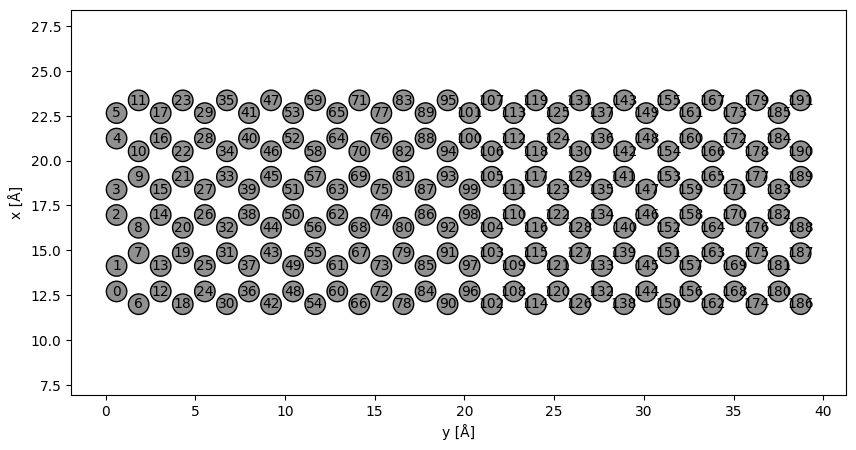

In [3]:
from functions import zgnr

Vpp_pi0=-2.7
Vpp_sigma0=-0.48

# N = 6 # width
# L = 1 # length
# num_cells = 24

N = 6 # width
L = 1 # length
num_cells = 16

nL = N*2
nR = N*2

NR = zgnr(N,L)

NR.rotate(90, (1, 0, 0), rotate_cell=False)

NR.cell[1] = [0, NR.cell[2,2],0]
NR.cell[2] = [0,0,50.0]


# center in the cell
NR.center()

# sort atoms by x, then y (correct order)
xyz = NR.get_positions()
sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

NR = NR[sorted_indices]

# repeat
NR = NR.repeat((1,num_cells,1))
# atoms = atoms.repeat((1,5,1))


print(NR.cell)
#view(NR)
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))

# Top flake

<Popen: returncode: None args: ['/home/oia/miniconda3/envs/abtem311/bin/pyth...>

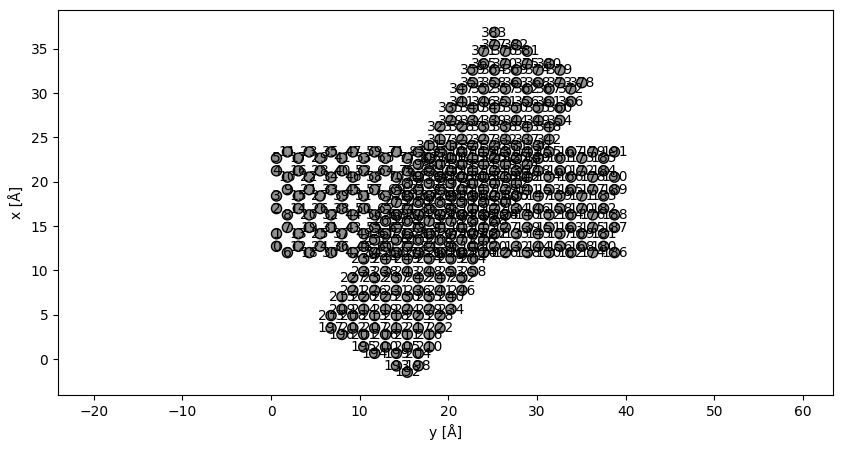

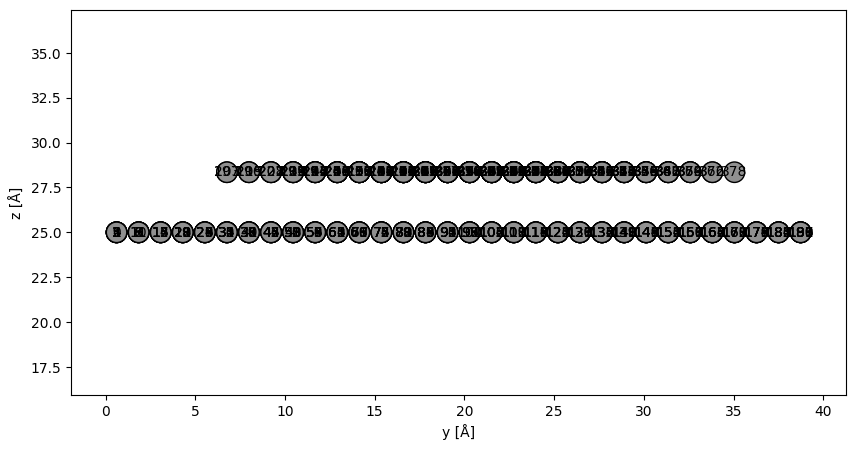

In [41]:
bottom = NR.copy()
top = NR.copy()

M = num_cells

top.positions[:,2] += 3.35
num_del = nL*(num_cells-M)/2
num_del = int(num_del)

del top[0:num_del]
del top[len(top)-num_del::]
# change symbol to Nitrogen for identification
# top.symbols = 'N'

# ROTATING TOP

# center atoms cordinats
CA1 = top.positions[int(nL/2)*(M-1)+int(nL/4)-1]
CA2 = top.positions[int(nL/2)*(M-1)+int(nL/4)]

# rotating angle
ang = 30

# going from AA to AB (only for ang = 30)
top.positions[:,0] += - np.sin(ang * np.pi/180)*(CA2[0]-CA1[0])/2
top.positions[:,1] += np.cos(ang * np.pi/180)*(CA2[0]-CA1[0])/2

# rotating
top.rotate(
    -90+ang,
    'z',
    center=(CA1[0]+(CA2[0]-CA1[0])/2, CA1[1], 3.0),
    rotate_cell=False
)



# merging
atoms = bottom + top

abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))
abtem.show_atoms(atoms,plane='yz',numbering=True,merge = False,show_cell=False,figsize=(10,5))

view(atoms)

# Hamilton

In [5]:
def slater_koster(
    atoms,
    cutoff=6,
    d0=1.42,
    d_gg=3.35,
    r0=0.45,
    Vpp_pi0=-2.7,
    Vpp_sigma0=-0.48,
    onsite=0.0,
    carbon_only=True
):
    """
    Compute Slater-Koster tight-binding Hamiltonian for graphene structures.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure
    cutoff : float, optional
        Cutoff distance for interlayer hopping in Angstrom, default is 6
    d0 : float, optional
        In-plane C-C bond length in Angstrom, default is 1.42
    d_gg : float, optional
        Interlayer distance in Angstrom, default is 3.35
    r0 : float, optional
        Decay length in Angstrom, default is 0.45
    Vpp_pi0 : float, optional
        Pi-orbital hopping parameter in eV, default is -2.7
    Vpp_sigma0 : float, optional
        Sigma-orbital hopping parameter in eV, default is 0.48
    onsite : float, optional
        On-site energy in eV, default is 0.0
    carbon_only : bool, optional
        Whether to consider only carbon atoms, default is True
    
    Returns
    -------
    H : np.ndarray
        Total Hamiltonian matrix (H_TB + H_SK)
    H_TB : np.ndarray
        In-plane tight-binding Hamiltonian
    H_SK : np.ndarray
        Slater-Koster interlayer Hamiltonian
    H_pi : np.ndarray
        Pi-orbital contribution
    H_sigma : np.ndarray
        Sigma-orbital contribution
    """
    pos = atoms.positions
    N = len(atoms)

    H_TB = np.zeros((N, N))
    H_pi = np.zeros((N, N),)
    H_sigma = np.zeros((N, N))

    # onsite term (pi channel)
    for i in range(N):
        if not carbon_only and atoms[i].symbol == 'N':
            H_pi[i, i] = onsite #+ 1.5  # Nitrogen has higher onsite energy
        else:
            H_pi[i, i] = onsite

    # In plane hopping
    for i in range(N):
        ri = pos[i]
        z_i=pos[i][2]
        for j in range(i + 1, N):
            rj = pos[j]
            z_j=pos[j][2]
            dvec = rj - ri
            R = np.linalg.norm(dvec)
            # check if the two atoms lie on the same z plane
            if np.abs(z_i-z_j) < 0.1: 
                 # Make TB hamiltonian
                 dist = np.linalg.norm(ri -rj, axis=0)
                 if  R < 1.5 and R > 0.1:
                    hop = Vpp_pi0
                    # Scale hopping for N-C or N-N bonds when carbon_only=False
                    if not carbon_only and (atoms[i].symbol == 'N' or atoms[j].symbol == 'N'):
                        hop *= 0.7 # Weaker hopping for N-containing bonds
                    H_TB[i, j] = hop
                    H_TB[j, i] = hop
            else:
                # Make SK
                if R < cutoff and R > 1e-8:
    
                    # angle factors
                    cos_theta = dvec[2] / R
                    cos2 = cos_theta**2
                    sin2 = 1.0 - cos2
    
                    # distance dependent hoppings
                    Vpi = Vpp_pi0 * np.exp(-(R - d0) / r0)
                    Vsigma = Vpp_sigma0 * np.exp(-(R - d_gg) / r0)
    
                    # separated contributions
                    t_pi = Vpi * sin2
                    t_sigma = Vsigma * cos2
    
                    # fill matrices
                    H_pi[i, j] = t_pi
                    H_pi[j, i] = t_pi
    
                    H_sigma[i, j] = t_sigma
                    H_sigma[j, i] = t_sigma


    H_SK = H_pi + H_sigma
    H = H_TB + H_SK
    return H,H_TB,H_SK,H_pi,H_sigma


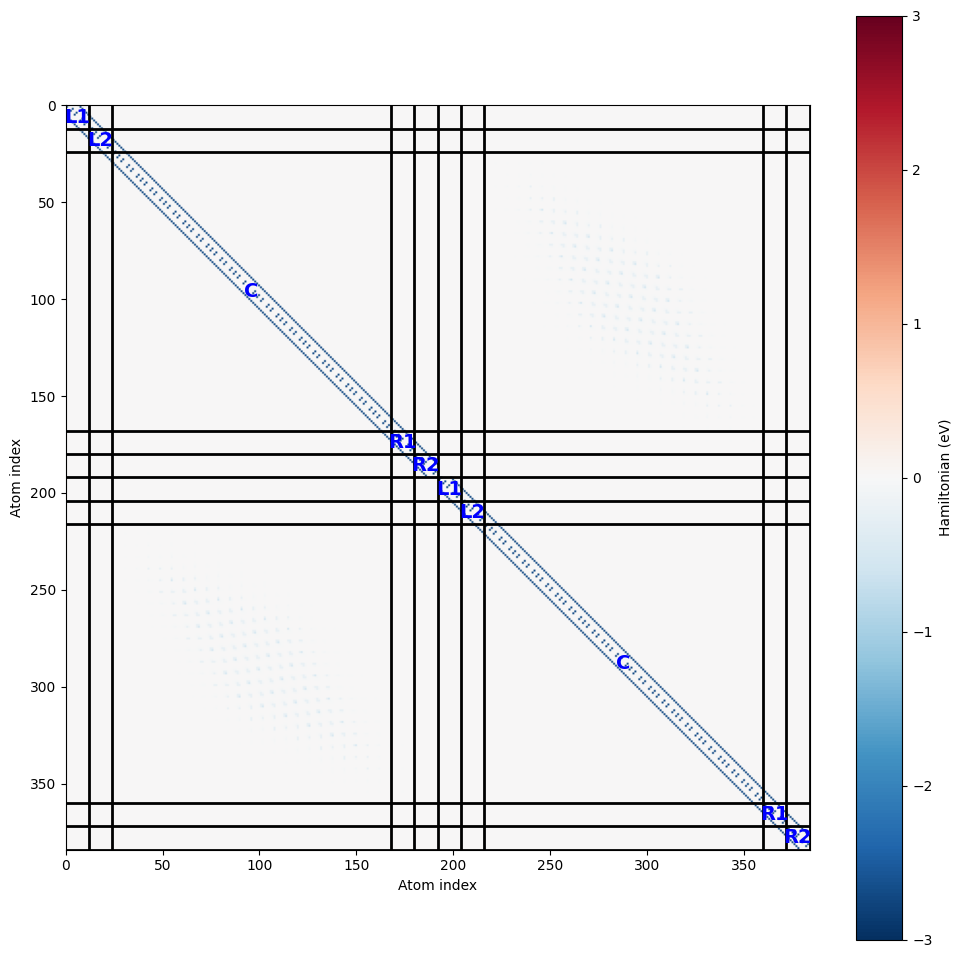

In [6]:
#from functions import slater_koster
H,H_TB,H_SK,_,_= slater_koster(atoms,carbon_only=True)

Hbig = H
nC = len(NR) - 2*nL - 2*nR

# Boundaries
b0 = 0
b1 = nL
b2 = 2*nL
b3 = 2*nL + nC
b4 = 2*nL + nC + nR
b5 = 2*nL + nC + 2*nR #Hbig.shape[0]

b6 = b5 + nL
b7 = b5 + 2*nL
b8 = b5 + 2*nL + nC
b9 = b5 + 2*nL + nC + nR
b10 = b5 + 2*nL + nC + 2*nR


plt.figure(figsize=(12,12))
# Use imshow with extent to align indices properly
n = Hbig.shape[0]
plt.imshow(Hbig, extent=(0, n, n, 0), cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar(label='Hamiltonian (eV)')

# Draw block boundaries
for b in [b1, b2, b3, b4,b5,b6,b7,b8,b9,b10]:
    plt.axhline(b, color='k', linewidth=2)
    plt.axvline(b, color='k', linewidth=2)

# Add text labels
plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='b', fontsize=14, weight='bold')

plt.text((b5+b6)/2, (b5+b6)/2, "L1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b6+b7)/2, (b6+b7)/2, "L2", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b7+b8)/2, (b7+b8)/2, "C", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b8+b9)/2, (b8+b9)/2, "R1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b9+b10)/2, (b9+b10)/2, "R2", ha='center', va='center', color='b', fontsize=14, weight='bold')

plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.show()


In [7]:
H

array([[ 0. , -2.7,  0. , ...,  0. ,  0. ,  0. ],
       [-2.7,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. , -2.7,  0. ],
       [ 0. ,  0. ,  0. , ..., -2.7,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]], shape=(384, 384))

In [23]:
def SplitHamMoySameStrips(H, nL, nR):
    """
    Partition Hamiltonian H with block structure:
    L1 | L2 | C | R1 | R2
    Device D = L2 | C | R1
    """

    no = H.shape[0]
    nC = int(no/2) - 2*nL - 2*nR 

    if nC < 1:
        print("Setup error: central region size =", nC)
        print("Use [L | L | C | R | R] setup")
        return

    # Boundaries
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = 2*nL + nC + 2*nR
    b6 = b5 + nL
    b7 = b5 + 2*nL
    b8 = b5 + 2*nL + nC
    b9 = b5 + 2*nL + nC + nR
    b10 = b5 + 2*nL + nC + 2*nR

    # Left lead onsite (L1)
    HL = H[b0:b1, b0:b1]

    # L2 → L1 hopping
    VL = H[b1:b2, b0:b1]

    # Coupling L2 ↔ C
    VCL = H[b2:b3, b1:b2]   # C → L2
    VLC = VCL.T.conj()      # L2 → C

    # Central region
    HC = H[b2:b3, b2:b3]

    # Coupling C ↔ R1
    VCR = H[b2:b3, b3:b4]   # C → R1
    VRC = VCR.T.conj()      # R1 → C

    # R1 → R2 hopping
    VR = H[b3:b4, b4:b5]

    # Right lead onsite (R2)
    HR = H[b4:b5, b4:b5]

    # Device block

    HD1 = H[b1:b4, b1:b4]
    HD2 = H[b6:b9, b6:b9]

    rows = np.r_[b1:b4, b6:b9]
    cols = np.r_[b1:b4, b6:b9]

    HD = H[np.ix_(rows, cols)]


    # Lead–device couplings
    VLD = H[b1:b4, b0:b1]   # L1 → device
    VRD = H[b1:b4, b4:b5]   # device → R2


    # Return in left → right order
    return HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HD1, HD2, rows

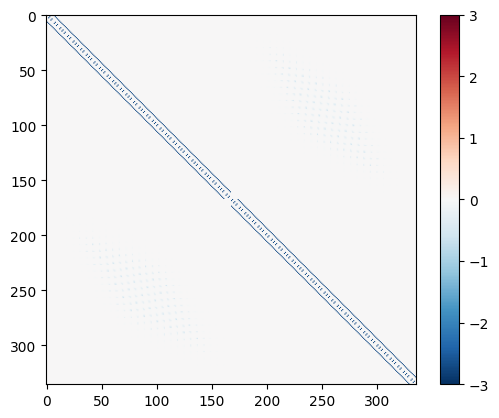

In [24]:
HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HD1, HD2,rows =SplitHamMoySameStrips(H, nL, nR)
plt.imshow(HD,  cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar()

# LDOS

In [17]:
from functions import get_surface_greens_function
def compute_transmission_caroli_v3(energy, eta,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=1 ):
    """
    For to equal strips!
    Computes transmission T(E) based on the formulas:
    Sigma_L = V_LD.dag @ g_L @ V_LD
    Sigma_R = V_RD @ g_R @ V_RD.dag
    T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
    """
    z = energy + 1j * eta

    # 1. Surface Green's Functions for leads
    gl_s,gl_b,sigmal_s,sigmal_b = get_surface_greens_function(HL, VL,z)
    gr_s,gr_b,sigmar_s,sigmar_b = get_surface_greens_function(HR, VR,z)

    if method == 2:

        # Infer sizes from blocks
        nL = HL.shape[0]
        nR = HR.shape[0]
        nC = HC.shape[0]
        dim = nL+nC+nR # of bottom device part
        


        nD = HD.shape[0]
        I = np.eye(nD, dtype=complex)

        h_eff = HD.astype(complex).copy()
        
        sigma_L = sigmal_s
        sigma_R = sigmar_s


        h_eff[0:nL, 0:nL] += sigma_L

        h_eff[nL+nC:dim, nL+nC:dim] += sigma_R #

        h_eff[dim:dim+nL, dim:dim+nL] += sigma_L

        h_eff[dim+nL+nC : 2*dim, dim+nL+nC : 2*dim] += sigma_R #

        g = np.linalg.inv(z * I - h_eff)

        

        gamma_BL = np.zeros((nD, nD), dtype=complex)
        gamma_BR = np.zeros((nD, nD), dtype=complex)
        gamma_TL = np.zeros((nD, nD), dtype=complex)
        gamma_TR = np.zeros((nD, nD), dtype=complex)

        gamma_BL[0:nL, 0:nL] = 1j * (sigma_L - sigma_L.T.conj())
        gamma_BR[nL + nC:dim, nL + nC:dim] = 1j * (sigma_R - sigma_R.T.conj())
        gamma_TL[dim:dim+nL, dim:dim+nL] = 1j * (sigma_L - sigma_L.T.conj())
        gamma_TR[dim+nL + nC:2*dim, dim+nL + nC:2*dim] = 1j * (sigma_R - sigma_R.T.conj())

        g_C = g
        t_matrixBR = gamma_BR @ g_C @ gamma_BL @ g.T.conj()
        t_matrixTL = gamma_TL @ g_C @ gamma_BL @ g.T.conj()
        t_matrixTR = gamma_TR @ g_C @ gamma_BL @ g.T.conj()

        
    # 5. Transmission T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
  
        transmissionBR= np.trace(t_matrixBR).real
        transmissionTL= np.trace(t_matrixTL).real
        transmissionTR= np.trace(t_matrixTR).real
    
    # 6. Current Jnm = 1/hbar*Im[Hnm*Anm] 
        ham = HD.astype(complex).copy()
        AL = g_C @ gamma_BL @ g.T.conj()
        
        hbar = 1#6.582119569e-16  # eV*s
        tol = 1e-6
        mask = ~np.isclose(ham, 0.0, atol=tol, rtol=0.0) #np.abs(ham) > tol # mask to only pick neigbors
        
        J = np.zeros_like(ham, dtype=float)
        J[mask] = (1/hbar) * np.imag(ham[mask] * AL[mask])
    

    return transmissionBR,transmissionTL,transmissionTR, g_C, J

In [18]:
# number of energies
N_E = 100

# Calculate spectrum
energies = np.linspace(-10.0, 10.0, N_E)
results = [compute_transmission_caroli_v3(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# Unpack each column of the results
transmissionBR,transmissionTL,transmissionTR, g_d, J = map(np.array, zip(*results))

# Compute DOS from gl_s
dos_D = np.array([
    -np.imag(np.trace(G)) / np.pi
    for G in g_d])

In [19]:
# data = np.loadtxt("AB-deg30width6.csv", delimiter=",", skiprows=1)
# energies = data[:, 0]
# transmissionBR = data[:, 1]
# transmissionTL = data[:, 2]
# transmissionTR = data[:, 3]
# dos_D = data[:, 4]

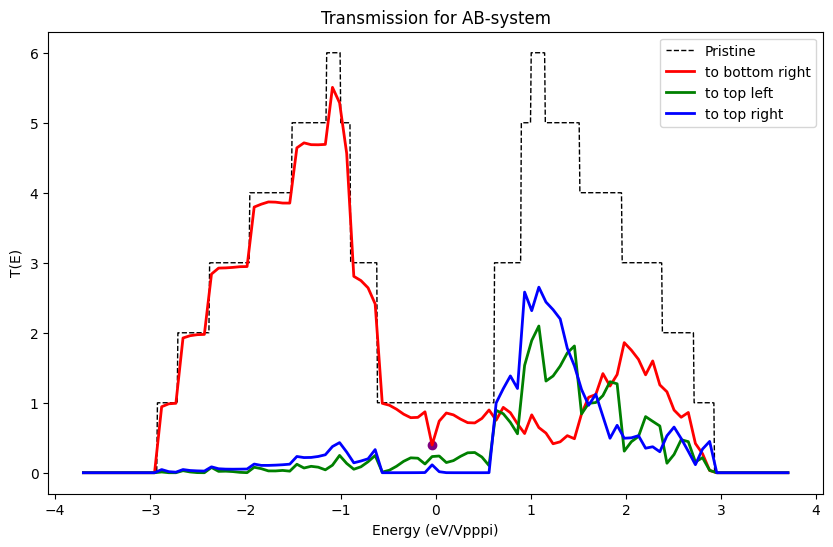

In [76]:
energy_idx = 50

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(energiesP/(-2.7), transmissionBRP, '--k', lw=1, label='Pristine')
plt.plot(energies/(-2.7), transmissionBR, '-r', lw=2, label='to bottom right')
plt.plot(energies/(-2.7), transmissionTL, '-g', lw=2, label='to top left')
plt.plot(energies/(-2.7), transmissionTR, '-b', lw=2, label='to top right')
plt.scatter(energies[energy_idx]/(-2.7),transmissionBR[energy_idx],color = 'purple')
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("T(E)")
plt.title("Transmission for AB-system")
plt.legend()
plt.show()

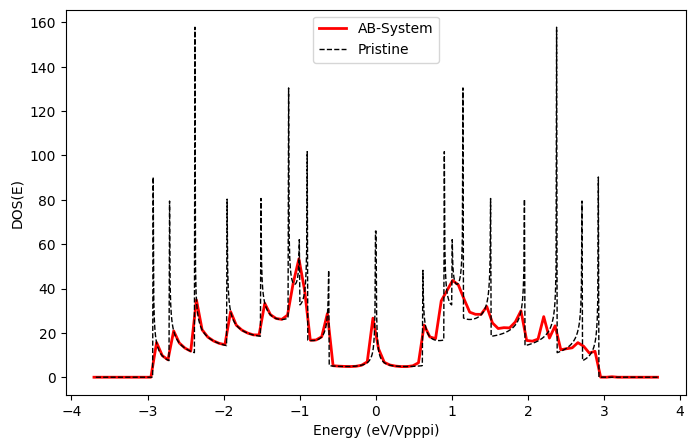

In [77]:
plt.figure(figsize=(8, 5))
#plt.plot(energies / (-2.7), dos_D1, color='k', lw=2,label='C')
plt.plot(energies / (-2.7), 
         dos_D, '-r', lw=2,label='AB-System')
plt.plot(energiesP / (-2.7), 
         dos_DP, '--k', lw=1,label='Pristine')
#plt.plot(energies / (-2.7), dos_D2_11, 'b', lw=2,)
#plt.scatter(energies[int(N_E/2)]/(-2.7),dos_D[int(N_E/2)],color = 'y')
#plt.plot(energies / (-2.7), dos_C2, '-r', lw=2,label='C')

plt.legend()
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("DOS(E)")
plt.show()

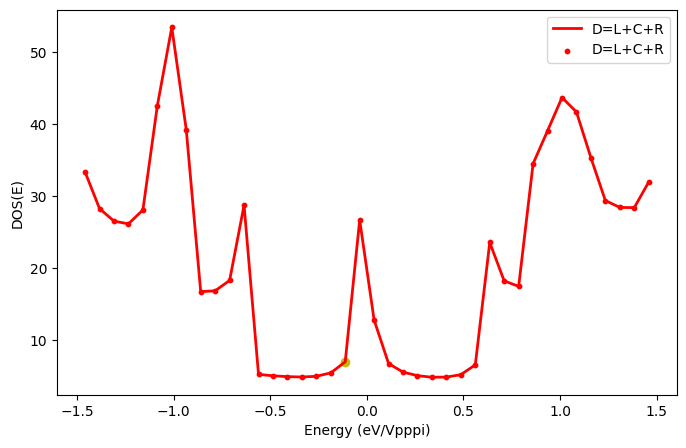

In [78]:
plt.figure(figsize=(8, 5))
#plt.plot(energies / (-2.7), dos_D1, color='k', lw=2,label='C')
plt.plot(energies[int(N_E/2)-20 : int(N_E/2)+20] / (-2.7), 
         dos_D[int(N_E/2)-20 : int(N_E/2)+20], '-r', lw=2,label='D=L+C+R')
plt.scatter(energies[int(N_E/2)-20 : int(N_E/2)+20] / (-2.7), 
         dos_D[int(N_E/2)-20 : int(N_E/2)+20], c='r',s=10,label='D=L+C+R')
#plt.plot(energies / (-2.7), dos_D2_11, 'b', lw=2,)
plt.scatter(energies[int(N_E/2)+1]/(-2.7),dos_D[int(N_E/2)+1],color = 'y')
#plt.plot(energies / (-2.7), dos_C2, '-r', lw=2,label='C')

plt.legend()
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("DOS(E)")
plt.show()

# bond current

In [79]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [80]:
bottom_idxs = range(nL,2*nL+nC+nR)
top_idxs = range(3*nL+nC+2*nR,len(H)-nR)

device_idxs = list(bottom_idxs) + list(top_idxs)

from matplotlib.patches import FancyArrowPatch

J_dev = J[energy_idx]          # must be same shape as HD (Ndev, Ndev)

# pick upper-triangle nonzeros in device indexing
iu, ju = np.triu_indices_from(J_dev, k=1)
sel = np.abs(J_dev[iu, ju]) > 1e-12

# device pairs
i_dev = iu[sel]
j_dev = ju[sel]

# map to full/ASE indices
I_full = rows[i_dev]
J_full = rows[j_dev]

# Get current magnitudes for colormap normalization
current_magnitudes = np.abs([J_dev[idv, jdv] for idv, jdv in zip(i_dev, j_dev)])
norm = mcolors.Normalize(vmin=current_magnitudes.min(), vmax=current_magnitudes.max())
cmap = cm.get_cmap('plasma') # viridis, plasma, inferno, magma, cividis, jet

/tmp/ipykernel_40679/3293488564.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma') # viridis, plasma, inferno, magma, cividis, jet


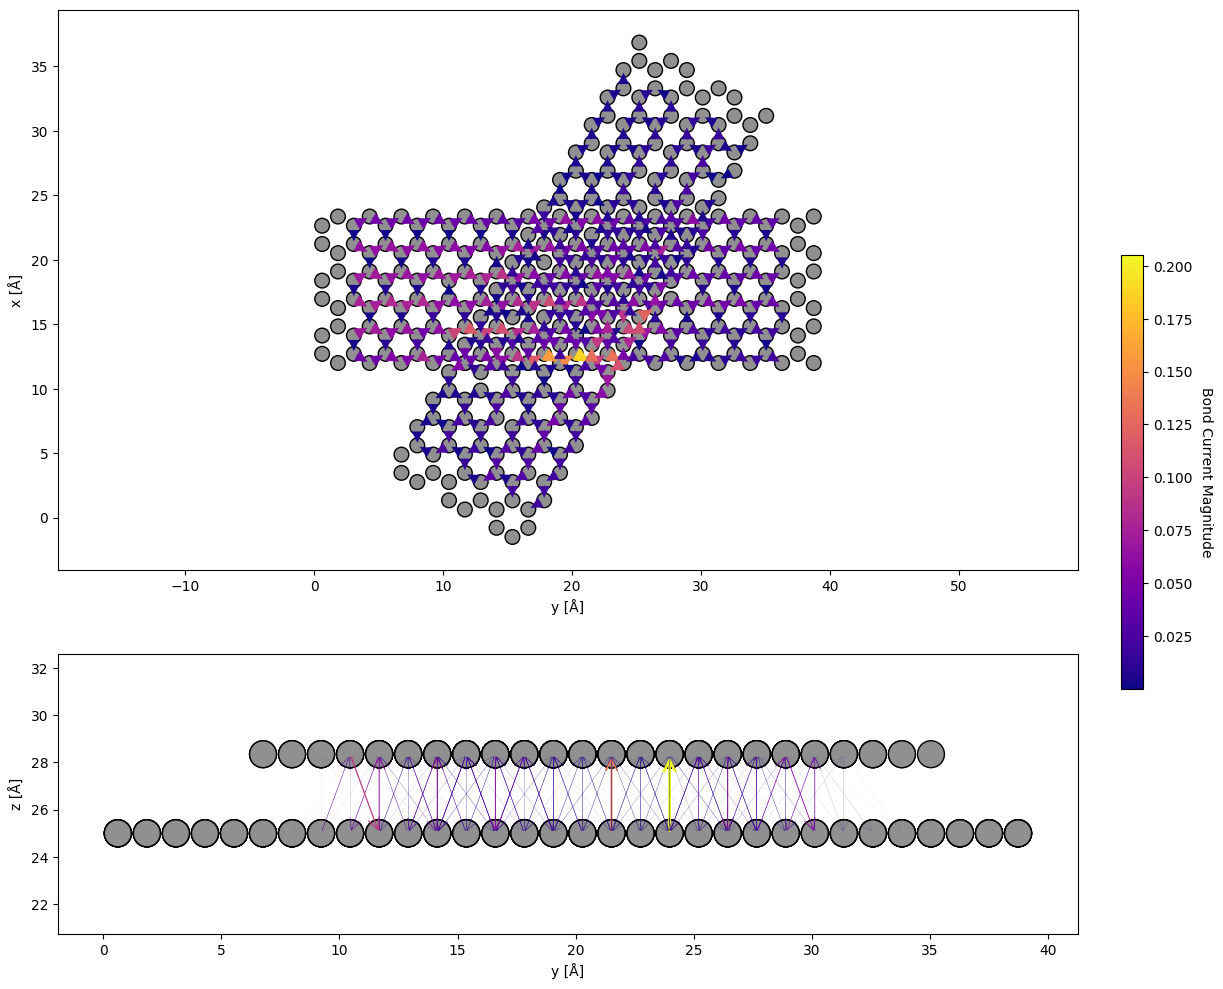

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), height_ratios=[2,1])

# YX plane (top view)
abtem.show_atoms(atoms, plane='yx', numbering=False, merge=False, show_cell=False, ax=ax1)

# #LDOS
# for i, idx in enumerate(bottom_idxs): 
#     ax1.scatter(atoms.positions[idx, 1], atoms.positions[idx, 0], 
#                s=-1000*np.imag(np.diag(g_d[energy_idx]))[i], c='r')

# YZ plane (side view 1)
abtem.show_atoms(atoms, plane='yz', numbering=False, merge=False, show_cell=False, ax=ax2)

# # LDOS
# for i, idx in enumerate(device_idxs): 
#     ax2.scatter(atoms.positions[idx, 1], atoms.positions[idx, 2], 
#                s=-1000*np.imag(np.diag(g_d[energy_idx]))[i], c='r')


# Add arrows to both planes
for idv, jdv, If, Jf in zip(i_dev, j_dev, I_full, J_full):
    Jnm = J_dev[idv, jdv]


    if np.abs(Jnm) > 0.001:
    
        x_n, y_n, z_n = atoms.positions[If, 0], atoms.positions[If, 1], atoms.positions[If, 2]
        x_m, y_m, z_m = atoms.positions[Jf, 0], atoms.positions[Jf, 1], atoms.positions[Jf, 2]
        
        # Check if atoms are in the same z-plane (in-plane current)
        in_plane = np.abs(z_n - z_m) < 0.1

        # Arrow properties
        col = cmap(norm(np.abs(Jnm)))
        lw = norm(np.abs(Jnm))*2

        # Reverse arrow direction if Jnm is negative
        if Jnm >= 0:
            start_yx, end_yx = (y_n, x_n), (y_m, x_m)
            start_yz, end_yz = (y_n, z_n), (y_m, z_m)
        else:
            start_yx, end_yx = (y_m, x_m), (y_n, x_n)
            start_yz, end_yz = (y_m, z_m), (y_n, z_n)
        
        # YX plane arrows - only plot if in-plane
        if in_plane:
            arrow_yx1 = FancyArrowPatch(
                start_yx, end_yx,
                arrowstyle='-|>',
                mutation_scale=20,
                linewidth=lw,
                color=col
            )
            ax1.add_patch(arrow_yx1)
        
        # YZ plane arrow - only plot if not in-plane (out-of-plane)
        if not in_plane:
            arrow_yz = FancyArrowPatch(
                start_yz, end_yz,
                arrowstyle='->', 
                mutation_scale=20,
                linewidth=lw,
                color=col
            )
            ax2.add_patch(arrow_yz)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Bond Current Magnitude', rotation=270, labelpad=15)

plt.show()    

# LDOS

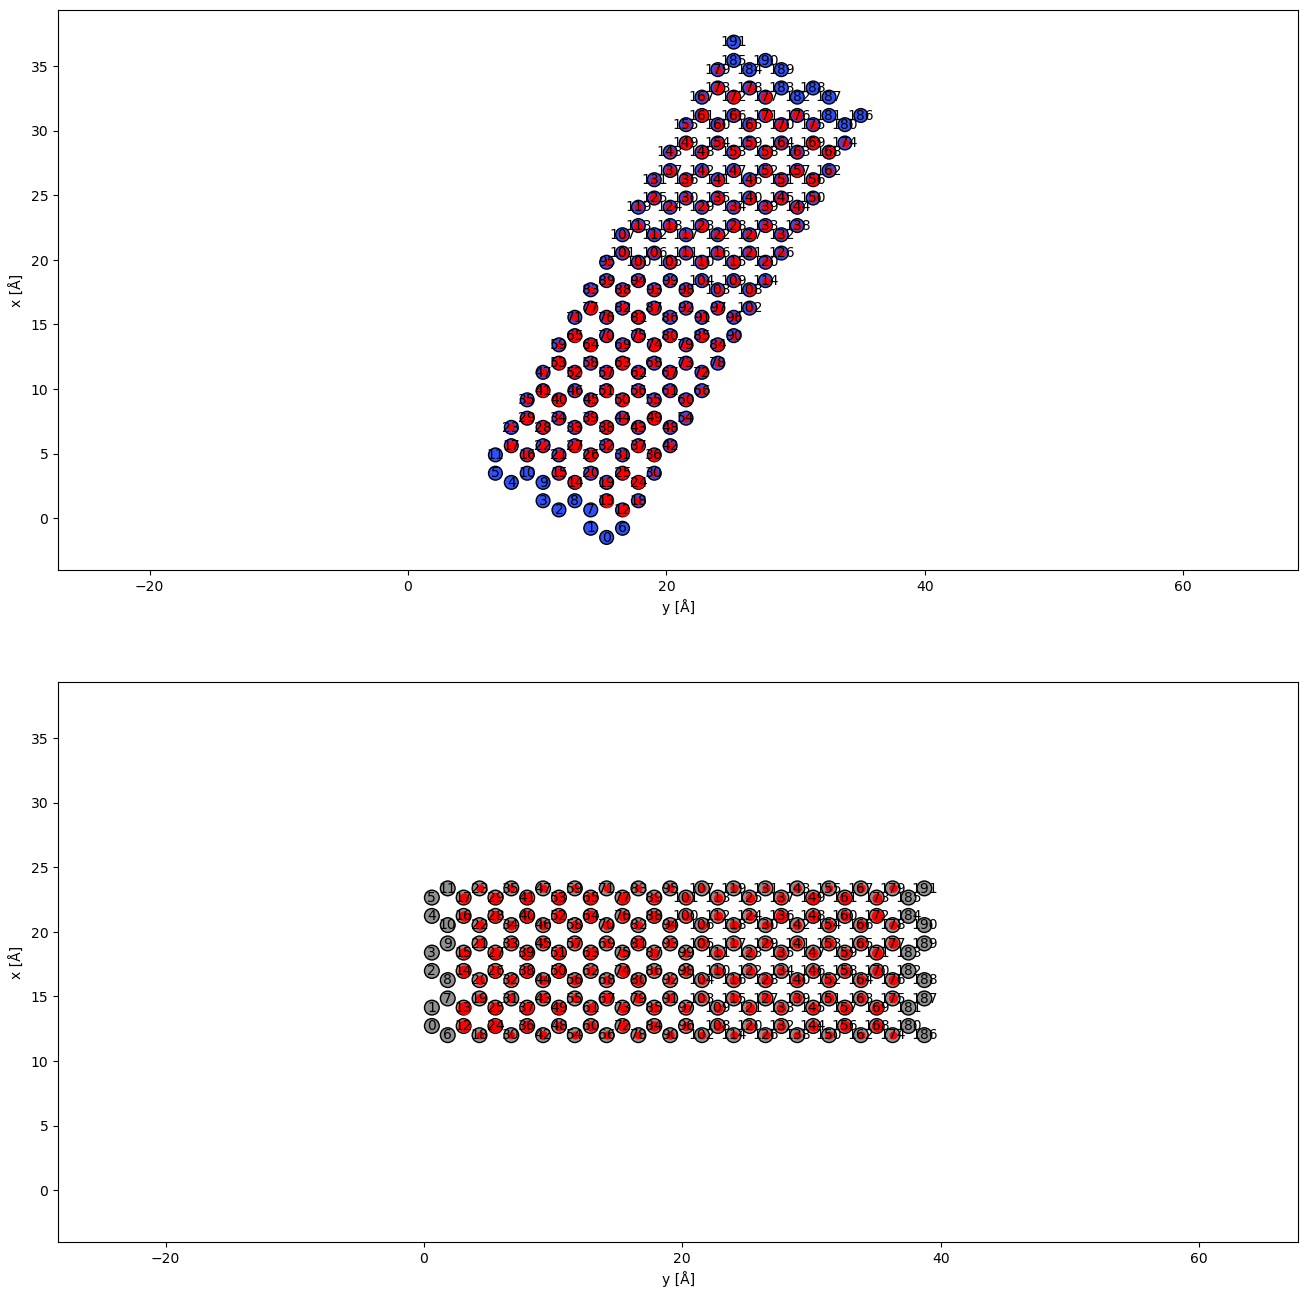

<Figure size 2000x800 with 0 Axes>

In [ ]:
#energy_idx = int(N_E/2)+1



fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(16, 16))
abtem.show_atoms(top,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax = ax1)

for i,idx in enumerate(top_idxs): 
    ax1.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-100*np.imag(np.diag(g_d[energy_idx]))[i],c='r')

plt.figure(figsize=(20, 8))
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax =ax2)

for i,idx in enumerate(bottom_idxs): 
    ax2.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-100*np.imag(np.diag(g_d[energy_idx]))[i],c='r')



# coordinates consistent with plane='yx'
x_n, y_n = atoms.positions[n, 1], atoms.positions[n, 0]
x_m, y_m = atoms.positions[m, 1], atoms.positions[m, 0]



NameError: name 'J' is not defined

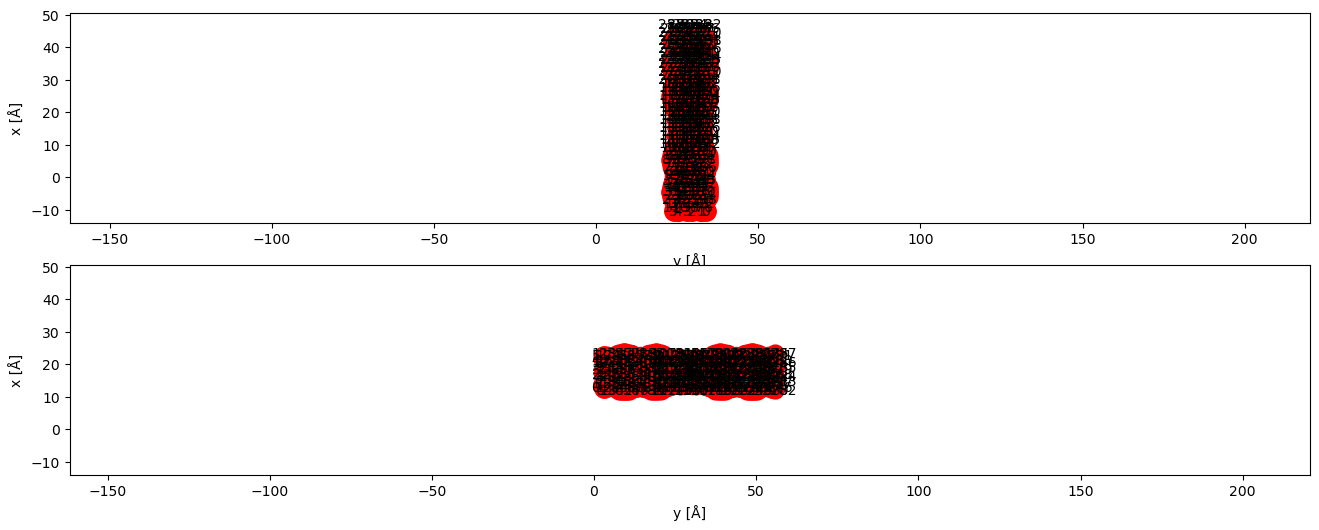

<Figure size 2000x800 with 0 Axes>

In [ ]:
bottom_idxs = range(nL,2*nL+nC+nR)
top_idxs = range(2*nL+nC+2*nR,len(H)-nR)

device_idxs = list(bottom_idxs) + list(top_idxs)

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(16, 6))
abtem.show_atoms(top,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax = ax1)

for i,idx in enumerate(top_idxs): 
    ax1.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')

plt.figure(figsize=(20, 8))
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax =ax2)

for i,idx in enumerate(bottom_idxs): 
    ax2.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')

# arrow
n, m = 6, 8
Jnm = J[energy_idx][n, m]

# coordinates consistent with plane='yx'
x_n, y_n = atoms.positions[n, 1], atoms.positions[n, 0]
x_m, y_m = atoms.positions[m, 1], atoms.positions[m, 0]

# thickness ~ strength (tune these two numbers)
lw = Jnm #0.5 + 10.0 * np.abs(Jnm)

# optional: color by sign
col = 'tab:blue' if Jnm >= 0 else 'tab:red'

# LOOP

In [ ]:
# ang = 30

# Vpp_pi0=-2.7
# Vpp_sigma0=-0.48
# #
# N = 6 # width
# L = 1 # length
# num_cells = 16

# nL = N*2
# nR = N*2

# NR = zgnr(N,L)

# NR.rotate(90, (1, 0, 0), rotate_cell=False)

# NR.cell[1] = [0, NR.cell[2,2],0]
# NR.cell[2] = [0,0,50.0]


# # center in the cell
# NR.center()

# # sort atoms by x, then y (correct order)
# xyz = NR.get_positions()
# sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

# NR = NR[sorted_indices]

# # repeat
# NR = NR.repeat((1,num_cells,1))
# # atoms = atoms.repeat((1,5,1))

# bottom = NR.copy()
# top = NR.copy()

# M = num_cells

# top.positions[:,2] += 3.35
# num_del = nL*(num_cells-M)/2
# num_del = int(num_del)

# del top[0:num_del]
# del top[len(top)-num_del::]
# # change symbol to Nitrogen for identification
# top.symbols = 'N'

# # ROTATING TOP

# # center atoms cordinats
# CA1 = top.positions[int(nL/2)*(M-1)+int(nL/4)-1]
# CA2 = top.positions[int(nL/2)*(M-1)+int(nL/4)]


# # going from AA to AB (only for ang = 30)
# top.positions[:,0] += - np.sin(ang * np.pi/180)*(CA2[0]-CA1[0])/2
# top.positions[:,1] += np.cos(ang * np.pi/180)*(CA2[0]-CA1[0])/2

# # rotating
# top.rotate(
#     -90+ang,
#     'z',
#     center=(CA1[0]+(CA2[0]-CA1[0])/2, CA1[1], 3.0),
#     rotate_cell=False
# )



# # merging
# atoms = bottom + top

# H,H_TB,H_SK,_,_= slater_koster(atoms,carbon_only=True)

# Hbig = H
# nC = len(NR) - 2*nL - 2*nR

# HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HD1, HD2 =SplitHamMoySameStrips(H, nL, nR)

# # number of energies
# N_E = 1000

# # Calculate spectrum
# energies = np.linspace(-10.0, 10.0, N_E)
# results = [compute_transmission_caroli_v3(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# # Unpack each column of the results
# transmissionBR,transmissionTL,transmissionTR, g_d = map(np.array, zip(*results))

# # save energies and transmission as csv 
# data = np.column_stack((energies, transmissionBR,transmissionTL,transmissionTR, dos_D))
# np.savetxt("AB-deg"+str(ang)+"width"+str(N)+".csv", data, delimiter=",", 
#            header="energiesP,transmissionBRP,transmissionTLP,transmissionTRP, dos_DP", 
#            comments='')